In [1]:
import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## NOTE: Normalize didn't happen in this one !!!

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [2]:
def dice_metric(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    
    intersection = 2.0 * (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2)
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def jaccard_index(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    intersection = (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2) - intersection
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

# def dice_loss(inputs, target):
#     num = target.size(0)
#     chans = target.size(1)
#     inputs = inputs.reshape(num*chans, -1)
#     target = target.reshape(num*chans, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / (num*chans)
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [3]:


class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))
        #super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, n_channels=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(n_channels,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out



# Load and define dataset


In [4]:
class DatasetSegmentation(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, transform = None, normalize_transform = None, interp_size = 512):
        super(DatasetSegmentation, self).__init__()
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.compose([
                transforms.Resize((interp_size, interp_size), interpolation=0)
            ])
        self.normalize_transform = None
        
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)
        
        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        
        samp = torch.cat((data, label))
        
        samp = self.transform(samp)
        data = samp[:-1]
        label = samp[-1].unsqueeze(0)
        
        if self.normalize_transform:
            data = self.normalize_transform(data)
            

#         data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
#         label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [5]:
import json

with open(os.path.join('data', 'yeast_processed_log_norm_area_50', 'stds.json'), 'r') as f:
    stds = json.load(f)
    
stds

[[0.025770969688892365,
  0.2516340911388397,
  0.023633282631635666,
  0.11163000762462616],
 [0.02316989190876484,
  0.22105874121189117,
  0.06039806827902794,
  0.1474960595369339]]

In [6]:
normalize_transform = transforms.Normalize(
                                    stds[0],
                                    stds[1])


class RandomTranspose(object):
    """Randomly transpose sample
    """

    def __call__(self, sample):
        transpose = random.random() < 0.5
        if transpose:
            # sample is CxHxW
            return torch.transpose(sample, -1, -2)
        else:
            return sample


transform_dict = {'train': transforms.Compose([
                transforms.Resize((512,512), interpolation=0),
                RandomTranspose(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ]),
             'val': transforms.Compose([
                transforms.Resize((512,512), interpolation=0),
            ])}

ds_train = DatasetSegmentation(os.path.join('data', 'yeast_processed_log_norm_area_50', 'train'), transform=transform_dict['train'], normalize_transform=normalize_transform)
ds_test = DatasetSegmentation(os.path.join('data', 'yeast_processed_log_norm_area_50', 'test'), transform=transform_dict['val'], normalize_transform=normalize_transform)
ds_val = DatasetSegmentation(os.path.join('data', 'yeast_processed_log_norm_area_50', 'val'), transform=transform_dict['val'], normalize_transform=normalize_transform)

In [7]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [8]:
sample = ds_train.__getitem__(13)

In [9]:
sample[1].shape

torch.Size([1, 512, 512])

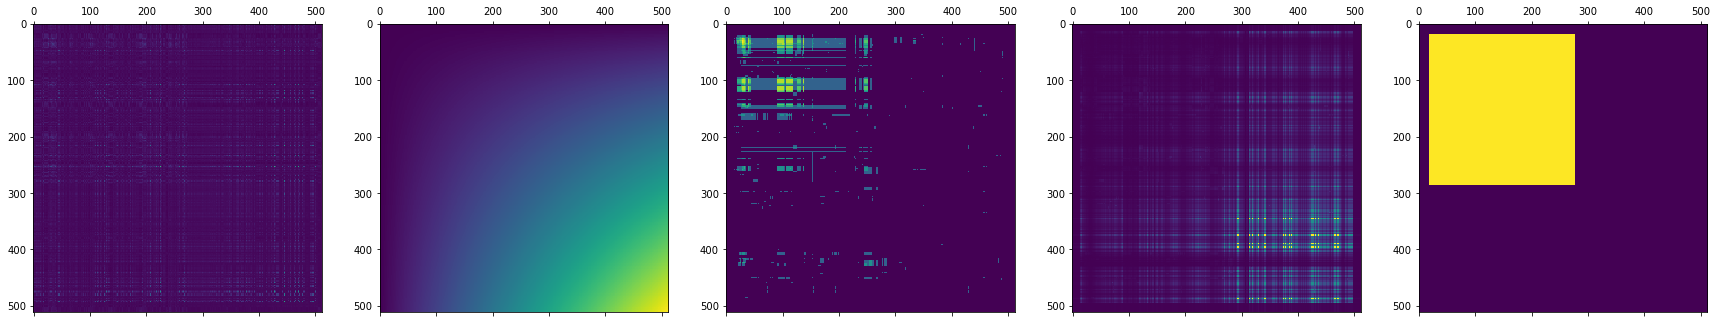

In [10]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0].view(512,512))
axs[1].matshow(sample[0][1].view(512,512))
axs[2].matshow(sample[0][2].view(512,512))
axs[3].matshow(sample[0][3].view(512,512))
axs[4].matshow(sample[1][0].view(512,512))
plt.show()

In [11]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=2, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=2, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=2, num_workers=0, shuffle=False)

# Setup Model 

In [12]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [13]:
# def dice_metric(inputs, target):
#     intersection = 2.0 * (target * inputs).sum()
#     union = target.sum() + inputs.sum()
#     if target.sum() == 0 and inputs.sum() == 0:
#         return 1.0

#     return intersection / union

# def dice_loss(inputs, target):
#     num = target.size(0)
#     inputs = inputs.reshape(num, -1)
#     target = target.reshape(num, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / num
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

criterion = bce_dice_loss

Setup optimizer

In [14]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [15]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

Start train...


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch:   0%|          | 0/446 [00:00<?, ?it/s]

epoch 0 train loss 1.3094405200449342 val loss 1.2740152925252914
epoch 1 train loss 1.2812620366635343 val loss 1.2715605880532945
epoch 2 train loss 1.2778950846783248 val loss 1.2708286685603005
epoch 3 train loss 1.2793332517414349 val loss 1.2674542197159357
epoch 4 train loss 1.2770527181603983 val loss 1.2768510324614388
epoch 5 train loss 1.2726217548408851 val loss 1.2684111211981093
epoch 6 train loss 1.2713733371597769 val loss 1.2666506000927515
epoch 7 train loss 1.271748973916999 val loss 1.2640941398484367
epoch 8 train loss 1.269424842612091 val loss 1.273490043623107
epoch 9 train loss 1.270917013621651 val loss 1.2597770180021013
epoch 10 train loss 1.2621557143237023 val loss 1.2655897906848363
epoch 11 train loss 1.255515091622357 val loss 1.2351346526827132
epoch 12 train loss 1.2484408764026624 val loss 1.2353407463857107
epoch 13 train loss 1.2447754203471368 val loss 1.23556906410626
epoch 14 train loss 1.2437179877084468 val loss 1.247721716761589
epoch 15 trai

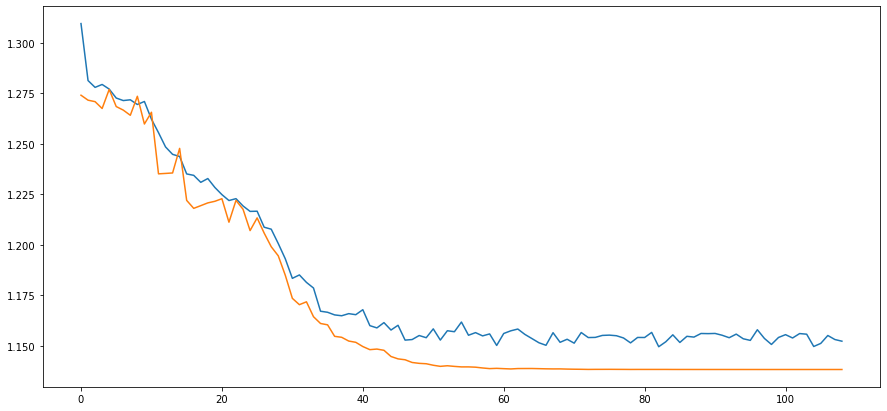

In [17]:
from tqdm.autonotebook import tqdm

if not os.path.isdir('models/unet2D_aug/yeast_processed_log_norm_area_50/'):
    os.mkdir('models/unet2D_aug/yeast_processed_log_norm_area_50/')

epochs = 1000
min_epochs = 20
early_stop_crit = 10

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')


early_stop_count = 0
# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epochs > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D_aug/yeast_processed_log_norm_area_50/checkpt_earlystop_{epoch}.pth')
        break
    
    early_stop_count += 1
    
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    
    # Change the learning rate
    scheduler.step()
    
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, './models/unet2D_aug/yeast_processed_log_norm_area_50/best_model.pth')
        early_stop_count = 0
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= 1-epochs:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/unet2D_aug/yeast_processed_log_norm_area_50/checkpt{epoch}.pth')
        
    # Print the results    
    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])


# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

# Evaluate

In [18]:
checkpoint = torch.load('./models/unet2D_aug/yeast_processed_log_norm_area_50/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [19]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask.sum(0))
#     cumsum_a = np.cumsum(mask.sum(1))
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1.0-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1.0-tail), side='left'))
#     return range_a, range_b
from scipy import ndimage
def mask_to_box(a):
    objs = ndimage.find_objects(a, max_label=1)

    # Get the height and width
    return objs

In [20]:
# import matplotlib

# cmap = mpl.cm.ScalarMappable
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm)
from matplotlib.patches import Rectangle

def plot_mask(mask_cpu, axx, round=False, title=None, bbs=[]):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    ax = axx.matshow(mask_cpu)
    if title:
        axx.set_title(title)
    axx.set_ylabel('Sequence A')
    axx.set_xlabel('Sequence B')
    ax.set_clim(0, 1)
    axx.set_xticks([])
    axx.set_yticks([])
    
    for bb in bbs:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
    
    plt.colorbar(ax, ax=axx)

<ipython-input-21-fbfecd6ff246>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(np.int))


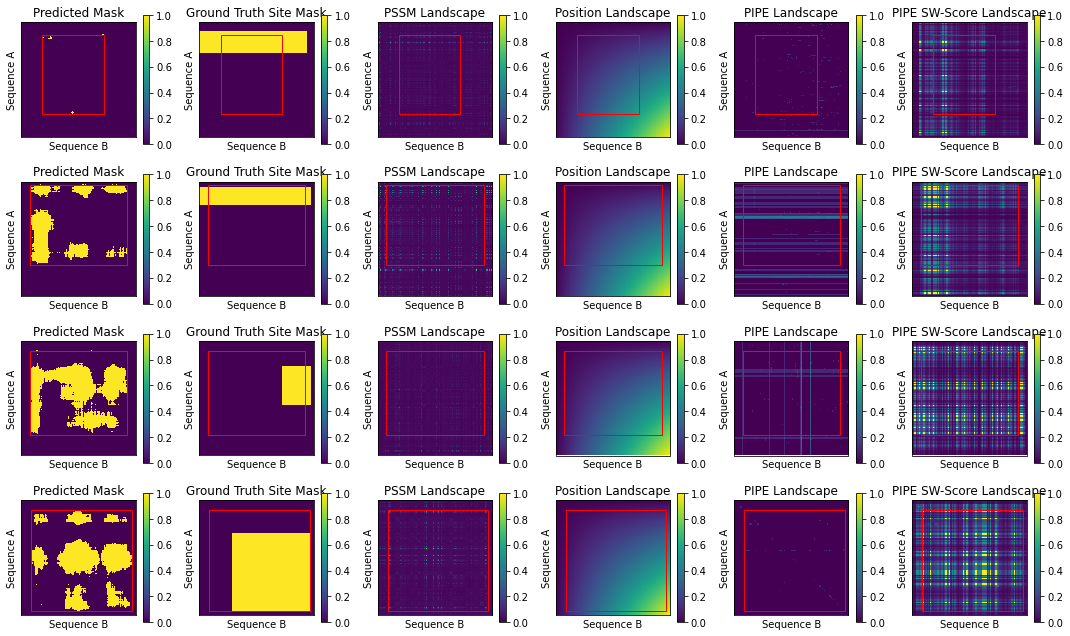

In [21]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(15, 9))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)

        # calculate bounding boxes
        bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(np.int))
#         bb25 = mask_to_box(pred[0,0,:,:], tail=0.25)
#         bb33 = mask_to_box(pred[0,0,:,:], tail=0.4)
        
        plot_mask(pred[0,0,:,:], ax[i][0], round=True, title="Predicted Mask", bbs=bbs)
        plot_mask(y[0,0,:,:], ax[i][1], title='Ground Truth Site Mask', bbs=bbs)
        plot_mask(x[0,0,:,:], ax[i][2], title='PSSM Landscape', bbs=bbs)
        plot_mask(x[0,1,:,:], ax[i][3], title='Position Landscape', bbs=bbs)
        plot_mask(x[0,2,:,:], ax[i][4], title='PIPE Landscape', bbs=bbs)
        plot_mask(x[0,3,:,:], ax[i][5], title='PIPE SW-Score Landscape', bbs=bbs)
        i+=1
        
plt.tight_layout()

# Function to compute the dice accuracy

In [22]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    jacc = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
        jacc.append(jaccard_index(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}, Jaccard Index: {np.mean(jacc)}')

# Compute dice accuracy for train, validation and test data

In [23]:
compute_acc(test_dataloader, model)

Loss: 1.1475962879402297, Accuracy (dice): 0.2968745827674866, Jaccard Index: 0.20219233632087708


In [24]:
compute_acc(train_dataloader, model)

Loss: 1.158964073577804, Accuracy (dice): 0.28762590885162354, Jaccard Index: 0.19615279138088226


In [25]:
compute_acc(val_dataloader, model)

Loss: 1.138381044779505, Accuracy (dice): 0.30378714203834534, Jaccard Index: 0.20916427671909332


## Test totally random

In [26]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])
model.cuda()
model.eval()
compute_acc(test_dataloader, model)

Loss: 1.4497832847493035, Accuracy (dice): 0.19569304585456848, Jaccard Index: 0.11385278403759003


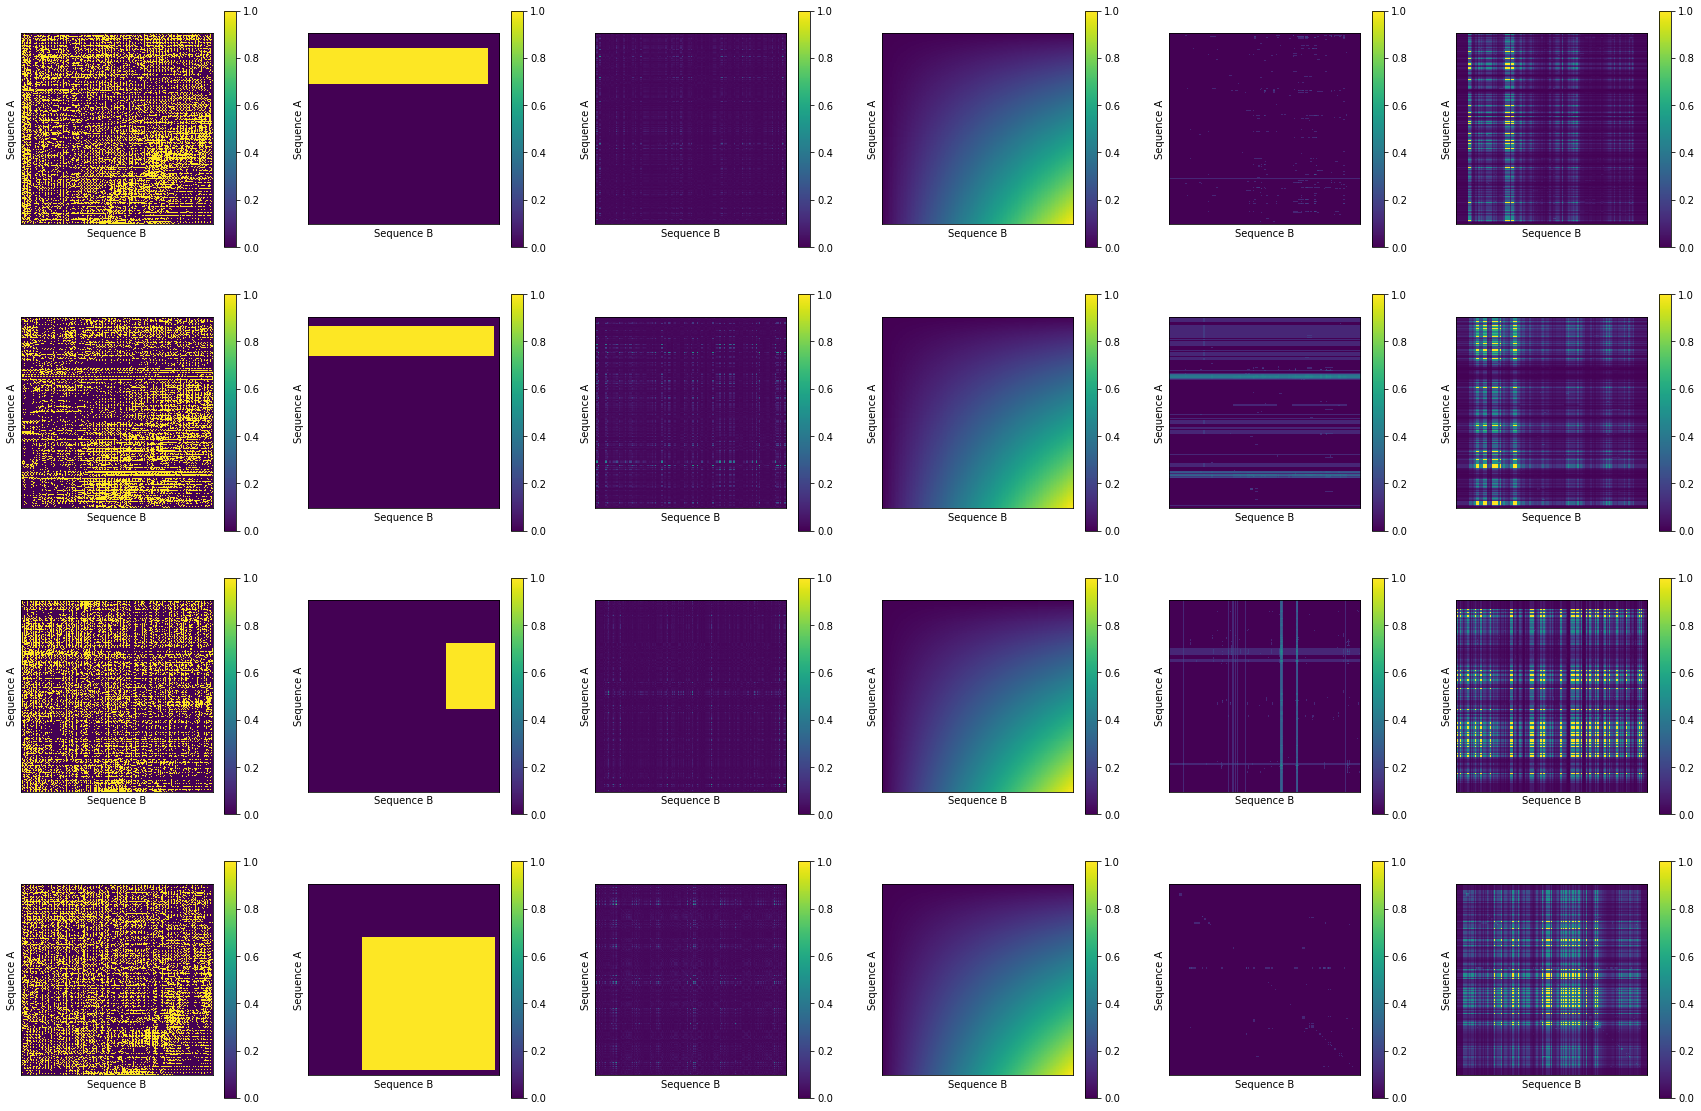

In [27]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Convert to bounding boxes

Create dataset object that can take pair names

In [50]:
class DatasetBB(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, transform = None, normalize_transform = None, interp_size = 512):
        super(DatasetBB, self).__init__()
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.compose([
                transforms.Resize((interp_size, interp_size), interpolation=0)
            ])
        self.normalize_transform = None
        
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        self.pair_names = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )
            self.pair_names.append(os.path.splitext(os.path.basename(img_path))[0])

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)
        
        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        
        samp = torch.cat((data, label))
        
        samp = self.transform(samp)
        data = samp[:-1]
        label = samp[-1].unsqueeze(0)
        
        if self.normalize_transform:
            data = self.normalize_transform(data)
            

#         data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
#         label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label, self.pair_names[index]

    def __len__(self):
        return len(self.img_files)


In [51]:
ds_test = DatasetBB(os.path.join('data', 'yeast_processed_log_norm_area_50', 'test'), transform=transform_dict['val'], normalize_transform=normalize_transform)
ds_val = DatasetBB(os.path.join('data', 'yeast_processed_log_norm_area_50', 'val'), transform=transform_dict['val'], normalize_transform=normalize_transform)

In [52]:
ds_test.__getitem__(0)

(tensor([[[2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4130e-02, 2.4130e-02, 2.6300e-02,  ..., 3.4546e-02,
           3.4546e-02, 1.7099e-02],
          ...,
          [1.6231e-02, 1.6231e-02, 1.6144e-02,  ..., 1.9096e-02,
           1.9096e-02, 3.3678e-02],
          [1.8054e-02, 1.8054e-02, 1.8835e-02,  ..., 2.8991e-02,
           2.8991e-02, 2.2073e-01],
          [1.5971e-02, 1.5971e-02, 1.5190e-02,  ..., 1.6318e-02,
           1.6318e-02, 2.6126e-02]],
 
         [[6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [1.2585e-05, 1.2585e-05, 2.5170e-05,  ..., 3.9013e-03,
           3.9013e-03, 3.9139e-03],
          ...,
          [3.2028e-03, 3.2028e-03, 6.4057e-03,  ..., 9.928

In [53]:
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, shuffle=False)

In [54]:
# data, mask, pairname = iter(test_dl).next()

In [55]:
# data.shape, mask.shape

In [56]:
# mask.to(device)

In [57]:
# pred = model(data.to(device))

In [58]:
# pred.shape

In [59]:
# torch.randn(2, 4).sum(0)

In [60]:
# cumsum_b = np.cumsum(pred.view(512,512).sum(0).cpu().numpy())
# cumsum_a = np.cumsum(pred.view(512,512).sum(1).cpu().numpy())

In [61]:
# tail=0.25
# np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail)), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail))

In [62]:
# plt.matshow(pred[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [63]:
# plt.matshow(mask[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [64]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask[0,0,:,:].max(0).cpu().numpy())
#     cumsum_a = np.cumsum(mask[0,0,:,:].max(1).cpu().numpy())
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))
#     return range_a, range_b

In [65]:
# cumsum_b = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=0)))
# cumsum_a = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=1)))

In [66]:
# plt.plot(cumsum_b)

In [67]:
# plt.plot(cumsum_a)

In [68]:
# tail=0.20
# (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))

In [69]:
# (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))

In [70]:
# np.quantile(cumsum_a, tail)

In [71]:
# np.quantile(cumsum_b, tail)

In [72]:
# ndimage.find_objects(np.zeros((50,50), dtype=np.int), max_label=1)

In [73]:
# plt.matshow(pred[0,0,:,:].cpu().numpy().round().astype(int))

In [74]:
# mask_to_box(mask[0,0,:,:].cpu().numpy().round().astype(int))

## Get predictions and turn them into bounding boxes

In [75]:
checkpoint = torch.load('./models/unet2D_aug/yeast_processed_log_norm_area_50/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)


bb_preds_test = []
bb_trues_test = []
pairnames_test = []
for _, (data, mask, pairname) in enumerate(test_dl):
    data, mask = data.to(device), mask.to(device)
    
    pred = model(data)
    
    pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int)
    mask = mask[0,0,:,:].cpu().numpy().round().astype(np.int)
    
    bb_preds_test.append(mask_to_box(pred))
    bb_trues_test.append(mask_to_box(mask))
    pairnames_test.append(pairname)
    
bb_preds_val = []
bb_trues_val = []
pairnames_val = []
for _, (data, mask, pairname) in enumerate(val_dl):
    data, mask = data.to(device), mask.to(device)
    
    pred = model(data)
    
    pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int)
    mask = mask[0,0,:,:].cpu().numpy().round().astype(np.int)
    
    bb_preds_val.append(mask_to_box(pred))
    bb_trues_val.append(mask_to_box(mask))
    pairnames_val.append(pairname)
    
import pandas as pd
test_df = pd.DataFrame(list(zip(pairnames_test, bb_preds_test, bb_trues_test)), columns=['pair', 'pred', 'true'])
val_df = pd.DataFrame(list(zip(pairnames_val, bb_preds_val, bb_trues_val)), columns=['pair', 'pred', 'true'])

<ipython-input-75-1f09592fa566>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = pred[0,0,:,:].cpu().numpy().round().astype(np.int)
<ipython-input-75-1f09592fa566>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [76]:
test_df

,pair,pred,true
0,"(P00830_P38077,)","[(slice(34, 474, None), slice(46, 478, None))]","[(slice(170, 389, None), slice(56, 511, None))]"
1,"(P06245_P05986,)","[(slice(94, 463, None), slice(110, 446, None))]","[(slice(93, 437, None), slice(112, 440, None))]"
2,"(P06780_P51862,)","[(slice(28, 458, None), slice(146, 496, None))]","[(slice(27, 454, None), slice(250, 319, None))]"
3,"(P06782_P38717,)","[(slice(38, 474, None), slice(46, 476, None))]","[(slice(44, 248, None), slice(129, 177, None))]"
4,"(P08018_P53599,)","[(slice(46, 478, None), slice(118, 494, None))]","[(slice(276, 478, None), slice(411, 506, None))]"
...,...,...,...
106,"(Q12189_Q12189,)","[(slice(54, 486, None), slice(62, 492, None))]","[(slice(145, 499, None), slice(145, 499, None))]"
107,"(Q12223_Q12223,)","[(slice(46, 398, None), slice(46, 462, None))]","[(slice(99, 433, None), slice(99, 433, None))]"
108,"(Q12329_Q12329,)","[(slice(47, 471, None), slice(64, 470, None))]","[(slice(336, 487, None), slice(336, 487, None))]"
109,"(Q12438_Q12438,)","[(slice(62, 478, None), slice(54, 478, None))]","[(slice(282, 428, None), slice(282, 428, None))]"


In [77]:
# -1 to make inclusive
deslice = lambda x: np.asarray([[x[0][0].start, x[0][0].stop-1], [x[0][1].start, x[0][1].stop-1]])

In [78]:
test_df[['pred', 'true']] = test_df[['pred', 'true']].applymap(deslice)
val_df[['pred', 'true']] = val_df[['pred', 'true']].applymap(deslice)

In [79]:
test_df

,pair,pred,true
0,"(P00830_P38077,)","[[34, 473], [46, 477]]","[[170, 388], [56, 510]]"
1,"(P06245_P05986,)","[[94, 462], [110, 445]]","[[93, 436], [112, 439]]"
2,"(P06780_P51862,)","[[28, 457], [146, 495]]","[[27, 453], [250, 318]]"
3,"(P06782_P38717,)","[[38, 473], [46, 475]]","[[44, 247], [129, 176]]"
4,"(P08018_P53599,)","[[46, 477], [118, 493]]","[[276, 477], [411, 505]]"
...,...,...,...
106,"(Q12189_Q12189,)","[[54, 485], [62, 491]]","[[145, 498], [145, 498]]"
107,"(Q12223_Q12223,)","[[46, 397], [46, 461]]","[[99, 432], [99, 432]]"
108,"(Q12329_Q12329,)","[[47, 470], [64, 469]]","[[336, 486], [336, 486]]"
109,"(Q12438_Q12438,)","[[62, 477], [54, 477]]","[[282, 427], [282, 427]]"


Get lengths of proteins

In [80]:
protein_sequence = "data/uniprot-proteome_UP000002311_stripped.fasta"
protein_sequence_CD = pd.read_csv(protein_sequence, header = None, sep = "\t")
print("Loaded UniProt proteome")
new_df_ps = pd.DataFrame(index = protein_sequence_CD[0].iloc[::2].map(lambda x: str(x)[1:].strip()))
new_df_ps['Sequence'] = protein_sequence_CD[0].iloc[1::2].to_numpy()
new_df_ps['Length'] = new_df_ps['Sequence'].map(lambda x: len(x))
new_df_ps

Loaded UniProt proteome


,Sequence,Length
0,,
P21192,MDNVVDPWYINPSGFAKDTQDEEYVQHHDNVNPTIPPPDNYILNNE...,770
P46993,MTTLASSIEHKTKHLAAPFENDENPWMKKYCCQCKSCKMSVPVQPW...,209
P47117,MSYLNNPAVVMDNGTGLTKLGFAGNDSPSWVFPTAIATAAPSNTKK...,449
P22768,MSKGKVCLAYSGGLDTSVILAWLLDQGYEVVAFMANVGQEEDFDAA...,420
P29311,MSTSREDSVYLAKLAEQAERYEEMVENMKTVASSGQELSVEERNLL...,267
...,...,...
P47049,MYEMSGIDSLFHDRVVHDYSHTSEQVIVVYISSAAGDNSWLHQWFK...,396
P53142,MNRILSSASLLSNVSMPRQNKHKITKALCYAIIVASIGSIQFGYHL...,486
Q05919,MKRFLLSRRQRHLRMICFHNISLFRANGDSKLIKEYGDGFIPCFFI...,439


In [81]:
test_df['pair'] = test_df['pair'].apply(lambda x: x[0]).str.split(pat='_')
test_df

,pair,pred,true
0,"[P00830, P38077]","[[34, 473], [46, 477]]","[[170, 388], [56, 510]]"
1,"[P06245, P05986]","[[94, 462], [110, 445]]","[[93, 436], [112, 439]]"
2,"[P06780, P51862]","[[28, 457], [146, 495]]","[[27, 453], [250, 318]]"
3,"[P06782, P38717]","[[38, 473], [46, 475]]","[[44, 247], [129, 176]]"
4,"[P08018, P53599]","[[46, 477], [118, 493]]","[[276, 477], [411, 505]]"
...,...,...,...
106,"[Q12189, Q12189]","[[54, 485], [62, 491]]","[[145, 498], [145, 498]]"
107,"[Q12223, Q12223]","[[46, 397], [46, 461]]","[[99, 432], [99, 432]]"
108,"[Q12329, Q12329]","[[47, 470], [64, 469]]","[[336, 486], [336, 486]]"
109,"[Q12438, Q12438]","[[62, 477], [54, 477]]","[[282, 427], [282, 427]]"


In [82]:
test_df[['protein_a', 'protein_b']] = pd.DataFrame(test_df['pair'].tolist(), index=test_df.index)
test_df.drop(['pair'], inplace=True, axis=1)
test_df

,pred,true,protein_a,protein_b
0,"[[34, 473], [46, 477]]","[[170, 388], [56, 510]]",P00830,P38077
1,"[[94, 462], [110, 445]]","[[93, 436], [112, 439]]",P06245,P05986
2,"[[28, 457], [146, 495]]","[[27, 453], [250, 318]]",P06780,P51862
3,"[[38, 473], [46, 475]]","[[44, 247], [129, 176]]",P06782,P38717
4,"[[46, 477], [118, 493]]","[[276, 477], [411, 505]]",P08018,P53599
...,...,...,...,...
106,"[[54, 485], [62, 491]]","[[145, 498], [145, 498]]",Q12189,Q12189
107,"[[46, 397], [46, 461]]","[[99, 432], [99, 432]]",Q12223,Q12223
108,"[[47, 470], [64, 469]]","[[336, 486], [336, 486]]",Q12329,Q12329
109,"[[62, 477], [54, 477]]","[[282, 427], [282, 427]]",Q12438,Q12438


In [83]:
test_df['len_a'] = test_df['protein_a'].apply(lambda x: new_df_ps.Length.loc[x])
test_df['len_b'] = test_df['protein_b'].apply(lambda x: new_df_ps.Length.loc[x])
test_df

,pred,true,protein_a,protein_b,len_a,len_b
0,"[[34, 473], [46, 477]]","[[170, 388], [56, 510]]",P00830,P38077,511,311
1,"[[94, 462], [110, 445]]","[[93, 436], [112, 439]]",P06245,P05986,380,398
2,"[[28, 457], [146, 495]]","[[27, 453], [250, 318]]",P06780,P51862,209,1356
3,"[[38, 473], [46, 475]]","[[44, 247], [129, 176]]",P06782,P38717,633,1229
4,"[[46, 477], [118, 493]]","[[276, 477], [411, 505]]",P08018,P53599,668,1579
...,...,...,...,...,...,...
106,"[[54, 485], [62, 491]]","[[145, 498], [145, 498]]",Q12189,Q12189,258,258
107,"[[46, 397], [46, 461]]","[[99, 432], [99, 432]]",Q12223,Q12223,238,238
108,"[[47, 470], [64, 469]]","[[336, 486], [336, 486]]",Q12329,Q12329,375,375
109,"[[62, 477], [54, 477]]","[[282, 427], [282, 427]]",Q12438,Q12438,231,231


In [84]:
# Formula adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_dice_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    assert bb1[0][0] < bb1[0][1]
    assert bb1[1][0] < bb1[1][1]
    assert bb2[0][0] < bb2[0][1]
    assert bb2[1][0] < bb2[1][1]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[1][0], bb2[1][0])
    y_top = max(bb1[0][0], bb2[0][0])
    x_right = min(bb1[1][1], bb2[1][1])
    y_bottom = min(bb1[0][1], bb2[0][1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0, 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # compute the area of both AABBs
    bb1_area = (bb1[1][1] - bb1[1][0] + 1) * (bb1[0][1] - bb1[0][0] + 1)
    bb2_area = (bb2[1][1] - bb2[1][0] + 1) * (bb2[0][1] - bb2[0][0] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    # dice
    dice =  2 * intersection_area / float(bb1_area + bb2_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou, dice

In [85]:
test_df['iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred, x.true), axis=1)
test_df[['iou', 'dice']] = pd.DataFrame(test_df['iou_dice'].tolist(), index=test_df.index)
test_df.drop(['iou_dice'], inplace=True, axis=1)

val_df['iou_dice'] = val_df.apply(lambda x: get_dice_iou(x.pred, x.true), axis=1)
val_df[['iou', 'dice']] = pd.DataFrame(val_df['iou_dice'].tolist(), index=val_df.index)
val_df.drop(['iou_dice'], inplace=True, axis=1)

In [86]:
test_df

,pred,true,protein_a,protein_b,len_a,len_b,iou,dice
0,"[[34, 473], [46, 477]]","[[170, 388], [56, 510]]",P00830,P38077,511,311,0.468397,0.637970
1,"[[94, 462], [110, 445]]","[[93, 436], [112, 439]]",P06245,P05986,380,398,0.905013,0.950139
2,"[[28, 457], [146, 495]]","[[27, 453], [250, 318]]",P06780,P51862,209,1356,0.195219,0.326667
3,"[[38, 473], [46, 475]]","[[44, 247], [129, 176]]",P06782,P38717,633,1229,0.052230,0.099274
4,"[[46, 477], [118, 493]]","[[276, 477], [411, 505]]",P08018,P53599,668,1579,0.101701,0.184625
...,...,...,...,...,...,...,...,...
106,"[[54, 485], [62, 491]]","[[145, 498], [145, 498]]",Q12189,Q12189,258,258,0.613892,0.760759
107,"[[46, 397], [46, 461]]","[[99, 432], [99, 432]]",Q12223,Q12223,238,238,0.631576,0.774191
108,"[[47, 470], [64, 469]]","[[336, 486], [336, 486]]",Q12329,Q12329,375,375,0.102287,0.185591
109,"[[62, 477], [54, 477]]","[[282, 427], [282, 427]]",Q12438,Q12438,231,231,0.120850,0.215640


In [87]:
val_df

,pair,pred,true,iou,dice
0,"(O94742_P46674,)","[[54, 469], [46, 493]]","[[116, 477], [78, 197]]",0.226768,0.369700
1,"(P00546_P20486,)","[[46, 481], [18, 365]]","[[13, 506], [93, 354]]",0.684335,0.812588
2,"(P00830_P30902,)","[[36, 417], [36, 457]]","[[170, 388], [9, 464]]",0.547987,0.707999
3,"(P02829_P38080,)","[[22, 483], [34, 149]]","[[132, 509], [31, 146]]",0.689789,0.816420
4,"(P03069_P03069,)","[[66, 473], [74, 473]]","[[407, 502], [407, 502]]",0.026732,0.052072
...,...,...,...,...,...
107,"(Q12241_P36015,)","[[46, 449], [38, 493]]","[[408, 502], [349, 504]]",0.031562,0.061193
108,"(Q12330_Q08963,)","[[46, 478], [38, 393]]","[[99, 501], [99, 389]]",0.687511,0.814823
109,"(Q12449_P53834,)","[[12, 473], [38, 473]]","[[18, 219], [41, 491]]",0.426522,0.597989
110,"(Q12460_P39990,)","[[54, 430], [58, 433]]","[[182, 420], [70, 455]]",0.591769,0.743536


## Distance Measure

The distance measure is as described in PIPE-Sites: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-225

In [88]:
def dm(pred, true, len_a, len_b):
    
    assert pred[0][0] < pred[0][1]
    assert pred[1][0] < pred[1][1]
    assert true[0][0] < true[0][1]
    assert true[1][0] < true[1][1]
    
    delta_a = max(true[0][0]-pred[0][0], pred[0][1]-true[0][1], 0)/len_a
    delta_b = max(true[1][0]-pred[1][0], pred[1][1]-true[1][1], 0)/len_b
    
    result = ((delta_a**2 + delta_b**2)**0.5)/(2**0.5)
    
    return result

In [89]:
test_df['dm'] = test_df.apply(lambda x: dm(x.pred, x.true, 512, 512), axis=1)
test_df

,pred,true,protein_a,protein_b,len_a,len_b,iou,dice,dm
0,"[[34, 473], [46, 477]]","[[170, 388], [56, 510]]",P00830,P38077,511,311,0.468397,0.637970,0.188332
1,"[[94, 462], [110, 445]]","[[93, 436], [112, 439]]",P06245,P05986,380,398,0.905013,0.950139,0.036851
2,"[[28, 457], [146, 495]]","[[27, 453], [250, 318]]",P06780,P51862,209,1356,0.195219,0.326667,0.244511
3,"[[38, 473], [46, 475]]","[[44, 247], [129, 176]]",P06782,P38717,633,1229,0.052230,0.099274,0.517628
4,"[[46, 477], [118, 493]]","[[276, 477], [411, 505]]",P08018,P53599,668,1579,0.101701,0.184625,0.514434
...,...,...,...,...,...,...,...,...,...
106,"[[54, 485], [62, 491]]","[[145, 498], [145, 498]]",Q12189,Q12189,258,258,0.613892,0.760759,0.170101
107,"[[46, 397], [46, 461]]","[[99, 432], [99, 432]]",Q12223,Q12223,238,238,0.631576,0.774191,0.103516
108,"[[47, 470], [64, 469]]","[[336, 486], [336, 486]]",Q12329,Q12329,375,375,0.102287,0.185591,0.548103
109,"[[62, 477], [54, 477]]","[[282, 427], [282, 427]]",Q12438,Q12438,231,231,0.120850,0.215640,0.437570


In [90]:
test_df[['iou', 'dice', 'dm']].describe()

,iou,dice,dm
count,111.000000,111.000000,111.000000
mean,0.237859,0.337805,0.389605
std,0.225137,0.261749,0.180648
min,0.000000,0.000000,0.001381
25%,0.071473,0.133408,0.271203
50%,0.158604,0.273785,0.399129
75%,0.330858,0.497206,0.514786
max,0.905013,0.950139,0.869143
